In [4]:
import pandas as pd
import csv
import seaborn as sns
import pytz
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, timedelta
from gurobipy import *

# 1.0 clean data

In [5]:
def convert_hvac_mode(x):
  if x=='off':
    return 0
  elif x=='cool':
    return 1
  elif x=='heat':
    return -1
  else:
    return 2

def convert_running_equipment(x):
  if x=='fan':
    return 1
  elif x=='compCool1,fan':
    return 2
  elif x=='compCool1,fan':
    return 3
  elif x=='fan,heatPump':
    return -1
  elif x=='auxHeat1,fan':
    return -2
  else:
    return 0

def utc_to_central(x):
    utc = pytz.timezone('UTC')
    central = pytz.timezone('US/Central')
    return x.replace(tzinfo=utc).astimezone(tz=central).strftime('%Y-%m-%d %H:%M:%S')

def utc_to_eastern(x):
    utc = pytz.timezone('UTC')
    eastern = pytz.timezone('US/Eastern')
    return x.replace(tzinfo=utc).astimezone(tz=eastern).strftime('%Y-%m-%d %H:%M:%S')

In [14]:
def get_tstat_data(thermostat_id, occpuied_start, occupied_end):
  t1 = df.loc[df['thermostat_id']==thermostat_id].copy()
  t1.index = pd.to_datetime(t1['timestamp'])
  # t1['local_time'] = [utc_to_eastern(x) for x in t1.index]
  # t1.set_index('local_time', inplace=True)
  # t1.index = pd.to_datetime(t1.index)
  t1['hour'] = [int(x.strftime('%H')) for x in t1.index]
  t1['weekday'] = [int(x.strftime('%w')) for x in t1.index]
  t1['time'] = [x.strftime('%H:%M') for x in t1.index]

  # add occupied, hvac mode and running equipment mode
  t1['occupied'] = [1 if (x>=occpuied_start) and (x<=occupied_end) else 0 for x in t1.time]
  t1.loc[t1['weekday'].isin([0,6]),['occupied']] = 0
  t1['hvac_mode'] = [convert_hvac_mode(x) for x in t1.hvac_mode]
  t1['running_equipment'] = [convert_running_equipment(x) for x in t1.running_equipment]

  t1['outside_temperature_c'] = (t1['outside_temperature_f']-32)/1.8
  t1['temperature_c'] = (t1['temperature_f']-32)/1.8
  t1['tstat_heat'] = 21 # add reference heating setpoint
  t1['tstat_heat_mesa'] = (t1['heat_setpoint_f']-32)/1.8
  t1['tstat_cool'] = 21 # add reference cooling setpoint
  t1['tstat_cool_mesa'] = (t1['cool_setpoint_f']-32)/1.8

  return t1

In [15]:
tstat_id = 521738394095
df = pd.read_csv('data/300SW/300 SW 1st Ave_{}.csv'.format(tstat_id))
t1 = get_tstat_data(tstat_id, '08:00', '18:00')
# t2 = get_tstat_data(thermostat_id=521713366534)
t1.head()

,timestamp,thermostat_id,thermostat_name,hvac_mode,heat_setpoint_f,cool_setpoint_f,temperature_f,humidity,events,outside_temperature_f,...,hour,weekday,time,occupied,outside_temperature_c,temperature_c,tstat_heat,tstat_heat_mesa,tstat_cool,tstat_cool_mesa
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-11-30 19:00:02,2021-11-30 19:00:02,521738394095,T3,0,69.0,78.0,61.1,69.0,[],71.1,...,19,2,19:00,0,21.722222,16.166667,21,20.555556,21,25.555556
2021-11-30 19:05:02,2021-11-30 19:05:02,521738394095,T3,0,69.0,78.0,61.1,69.0,[],71.1,...,19,2,19:05,0,21.722222,16.166667,21,20.555556,21,25.555556
2021-11-30 19:10:04,2021-11-30 19:10:04,521738394095,T3,0,69.0,78.0,61.1,69.0,[],70.6,...,19,2,19:10,0,21.444444,16.166667,21,20.555556,21,25.555556
2021-11-30 19:15:02,2021-11-30 19:15:02,521738394095,T3,0,69.0,78.0,61.1,69.0,[],70.6,...,19,2,19:15,0,21.444444,16.166667,21,20.555556,21,25.555556
2021-11-30 19:20:02,2021-11-30 19:20:02,521738394095,T3,0,69.0,78.0,61.1,69.0,[],70.6,...,19,2,19:20,0,21.444444,16.166667,21,20.555556,21,25.555556


<AxesSubplot:xlabel='timestamp'>

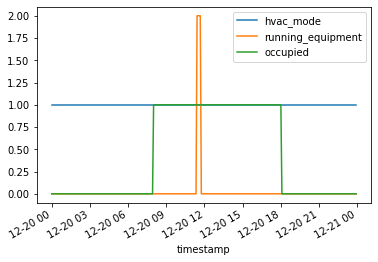

In [16]:
t1.loc['2021-12-20':'2021-12-20',['hvac_mode', 'running_equipment','occupied']].plot()

<AxesSubplot:xlabel='timestamp'>

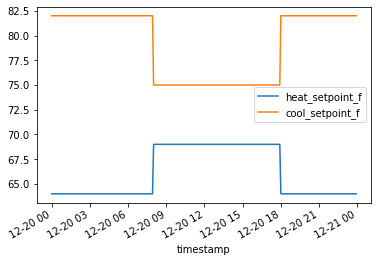

In [11]:
t1.loc['2021-12-20':'2021-12-20',['heat_setpoint_f', 'cool_setpoint_f']].plot()

# 2.0 Linear model for packaged AC unit

## model formulation, define model parameters from building

Tr: room temperature
Tm: temperature of the building's lumped thermal mass
Cr: thermal capacitance of the room
Cm: thermal capacitance of the thermal mass
Ta: ambient temperature
Rra: thermal resistance between the room and the ambient
Rrm: thermal resistance between the room and the thermal mass
G: solar irradiance
Sa: solar irradiance absorption factor
Ig: internal heat gain


In [ ]:
# prepare the modeling training dataset
# Tr, m, Ta, G, and I
Tr = t1['temperature_c'].values
Ta = t1['outside_temperature_c'].values
G = t1['']
Ig = t1['occupied'].values

In [12]:
# model
m = Model("AirConditioner")

# add model parameters
N = len(t1)
a11 = m.addVar(name='a11')
a12 = m.addVar(name='a12')
a21 = m.addVar(name='a21')
a22 = m.addVar(name='a22')
b = m.addVar(name='b')
d11 = m.addVar(name='d11')
d12 = m.addVar(name='d12')
d13 = m.addVar(name='d13')

Tr_hat = {}
Tm_hat = {}
Tm = {}

for k in range(N):
    Tr_hat[k] = m.addVar(name='Tr_hat_%s' % (k))
#     Tm_hat[k] = m.addVar(name='Tm_hat_%s' % (k))
#     Tm[k] = m.addVar(name='Tm_%s' % (k))
    
# for k in range(M):
#     Tr_hat[k] = m.addVar(name='Tr_hat_%s' % (k))
#     Tm_hat[k] = m.addVar(name='Tm_hat_%s' % (k))
#     Tm[k] = m.addVar(name='Tm_%s' % (k))
    

In [ ]:
# add model constraints
m.addConstr(a11 >= 0, 'c2')
m.addConstr(a12 >= 0, 'c3')
# m.addConstr(a21 >= 0, 'c4')
m.addConstr(b >= 0, 'c5')
m.addConstr(d11 >= 0, 'c6')
m.addConstr(d12 >= 0, 'c7')
m.addConstr(d13 >= 0, 'c8')

for k in range(N-1):
    m.addConstr(Tr_hat[k+1] == (a11)*Tr[k] + b*Ts[k]*mf[k] + (-b)*Tr[k]*mf[k] + d11*Ta[k] + d12*G[k] + d13*Ig[k], 'c0_%s' % (k))

# for k in range(M):
#     m.addConstr(Tr_hat[k] == a11*Tr[k] + a12*Tm[k] + b*Ts[k]*mf[k] + (-b)*Tr[k]*mf[k] + d11*Ta[k] + d12*G[k] + d13*Ig[k], 'c0_%s' % (k))
#     m.addConstr(Tm_hat[k] == a21*Tr[k] + a22*Tm[k], 'c1_%s' % (k))
#     m.addConstr(0.01*Tr[k] <= Tm[k] <= 2.5*Tr[k], 'c2_%s' % (k))
    

In [ ]:
#Let's define a class for each TCL
def get_t_off(R,C,setpoint,deadbandwidth,ambient,current,gamma=0,cooling=True):
    if current==ambient:
        t_off=24
    else:
        if cooling==True:
            t_off=-1*R*C*np.log((setpoint+gamma+deadbandwidth/2-ambient)/(current-ambient))
        else:
            t_off=-1*R*C*np.log((setpoint+gamma-deadbandwidth/2-ambient)/(current-ambient))
    if t_off<0:
        t_off=np.nan
    return t_off

class Airconditioner(object):
    """
    An airconditioner class 

    """
    class_counter= 0
    def __init__(self, timestep,setpoint,ambient_temp=20,cooling=True,err_sigma=0.01):
        
        """Return a Customer object whose name is *name* and starting
        balance is *balance*."""
        self.type='Airconditioner'
        Airconditioner.class_counter +=1
        self.id='AC'+str(Airconditioner.class_counter)
        self.cooling=cooling
        self.timestep = timestep #Has to be in hours        
        self.resistance= np.random.uniform(1.5,2.5,1)[0]
        self.capacitance= np.random.uniform(3.5,3.5,1)[0]
        self.power=np.random.uniform(4,4,1)[0]
        self.cop=2.5
        self.status=np.random.randint(0,1)
        self.coolingpower=self.power*self.cop
        self.deadbandwidth=np.random.uniform(0.5,0.5,1)[0]       
#         self.setpoint=np.random.uniform(23,23,1)[0]    
        self.setpoint=setpoint
        self.interior_temp=np.random.uniform(self.setpoint-self.deadbandwidth/2,self.setpoint+self.deadbandwidth/2,1)[0]
        self.ambient_temp=ambient_temp
        self.toff=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,0,self.cooling)

        self.err_sigma=err_sigma
        
        if self.cooling:
            self.gain=self.coolingpower*self.resistance
        else:
            self.gain=-1*self.coolingpower*self.resistance

        self.setpoint_DR=self.setpoint 
        self.interior_temp_DR=self.interior_temp
        self.status_DR=self.status
        self.curTempNoise=np.random.normal(0, self.err_sigma, 1)[0]
       
    def next_interior(self):
        """Return the next timestep interior temperature"""
        #Implement thermostatic action:
        self.curTempNoise=np.random.normal(0, self.err_sigma, 1)[0]
        if self.cooling:
            if self.ambient_temp>self.interior_temp:
                if self.interior_temp<=(self.setpoint-self.deadbandwidth/2):
                    self.status=0
                if self.interior_temp>=(self.setpoint+self.deadbandwidth/2):
                    self.status=1
            else:
                self.status=0
        else: # if it is a heating device.
            if self.ambient_temp<self.interior_temp:
                if self.interior_temp<=(self.setpoint-self.deadbandwidth/2):
                    self.status=1
                if self.interior_temp>=(self.setpoint+self.deadbandwidth/2):
                    self.status=0
            else:
                self.status=0
        alpha=np.exp(-1*self.timestep/(self.capacitance*self.resistance))
        self.interior_temp=self.interior_temp*alpha+(1-alpha)*(self.ambient_temp-(self.status*self.gain))+self.curTempNoise


    def get_toff(self):
        """Return t_off given gamma"""
        self.toff=get_t_off(self.resistance,self.capacitance,self.setpoint,self.deadbandwidth,self.ambient_temp,self.interior_temp,0,self.cooling)

    def changeDRSetPoint(self,newSetPoint):
        """Assign a DR setpoint"""
        self.setpoint_DR=newSetPoint
        
    def next_interior_DR(self):
        """Return the next timestep interior temperature"""
        #Implement thermostatic action:
        if self.cooling:
            if self.ambient_temp>self.interior_temp_DR:
                if self.interior_temp_DR<=(self.setpoint_DR-self.deadbandwidth/2):
                    self.status_DR=0
                if self.interior_temp_DR>=(self.setpoint_DR+self.deadbandwidth/2):
                    self.status_DR=1
            else:
                self.status_DR=0
        else: # if it is a heating device.
            if self.ambient_temp<self.interior_temp_DR:
                if self.interior_temp_DR<=(self.setpoint_DR-self.deadbandwidth/2):
                    self.status_DR=1
                if self.interior_temp_DR>=(self.setpoint_DR+self.deadbandwidth/2):
                    self.status_DR=0
            else:
                self.status_DR=0

              
        alpha=np.exp(-1*self.timestep/(self.capacitance*self.resistance))
        self.interior_temp_DR=self.interior_temp_DR*alpha+(1-alpha)*(self.ambient_temp-(self.status_DR*self.gain))+self.curTempNoise #+np.random.normal(0, self.err_sigma, 1)[0]

